In [1]:
# Real life data

import logging
import threading
import itertools
import json
import os
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func

from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
import skimage as ski

from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

#### Train a 2-layered LSTM in Watson Machine Learning

 
Telemanom ([Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding](https://arxiv.org/pdf/1802.04431.pdf) - 2018


Let's find out first what ML libraries are supported by WML.


### Basic Definitions

Forecast 24 data points from a sequence length of 200

In [2]:
#Forecasting
import pyrenn as prn


n_predictions = 24
n_sequence_length = 100

logger = logging

In [3]:
# load data
df_input = pd.read_csv('AllOfArmstark.csv', parse_dates=['timestamp'], comment='#')
#df_input = df_input.asfreq('H')
df_input = df_input.sort_values(by='timestamp').set_index('timestamp')

#df_temp = df_input[['Vx']].shift(1, freq='1D')
df_input['Vx_1'] = df_input[['Vx']].shift(1440)
df_input.dropna(inplace=True)



In [4]:
df_input['on'] = np.where(df_input['As'] > 0.2, 'M', 'F')
df_input['on'] = df_input['on'].astype('category')
df_1 = df_input[df_input['entity'] == '04714B6046D5']
df_2 = df_input[df_input['entity'] == '04714B604101']

df_1.describe()


,Vx,Vy,Vz,Ap,As,speed,Vx_1
count,128580.000000,128580.000000,128580.000000,128580.000000,128580.000000,128580.000000,128580.000000
mean,0.007284,-0.028294,-0.967962,2.453587,0.987402,0.987533,0.004984
std,0.037609,0.021309,0.049222,0.859291,0.265083,0.264592,0.040814
min,-0.223600,-0.122100,-1.163100,0.000000,0.000000,0.000000,-0.337900
25%,-0.014600,-0.042000,-1.000000,2.251600,1.036000,1.036000,-0.018600
50%,0.006800,-0.028300,-0.967800,2.313400,1.037000,1.037000,0.005900
75%,0.030300,-0.014600,-0.935500,2.699600,1.063000,1.064136,0.029300
max,0.290000,0.075200,-0.753900,5.334001,1.197000,1.195605,0.342800


In [5]:
sz = 500
df_1['max'] = sp.ndimage.maximum_filter1d(df_1['Vx'], size=sz)
df_2['max'] = sp.ndimage.maximum_filter1d(df_2['Vx'], size=sz)
df_1['max_1'] = sp.ndimage.maximum_filter1d(df_1['Vx_1'], size=sz)
df_2['max_1'] = sp.ndimage.maximum_filter1d(df_2['Vx_1'], size=sz)

<ipython-input-5-e5cbea8455b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['max'] = sp.ndimage.maximum_filter1d(df_1['Vx'], size=sz)
<ipython-input-5-e5cbea8455b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['max'] = sp.ndimage.maximum_filter1d(df_2['Vx'], size=sz)
<ipython-input-5-e5cbea8455b3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

2020-11-11T09:57:03.127 INFO numexpr.utils._init_num_threads Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-11-11T09:57:03.128 INFO numexpr.utils._init_num_threads NumExpr defaulting to 8 threads.


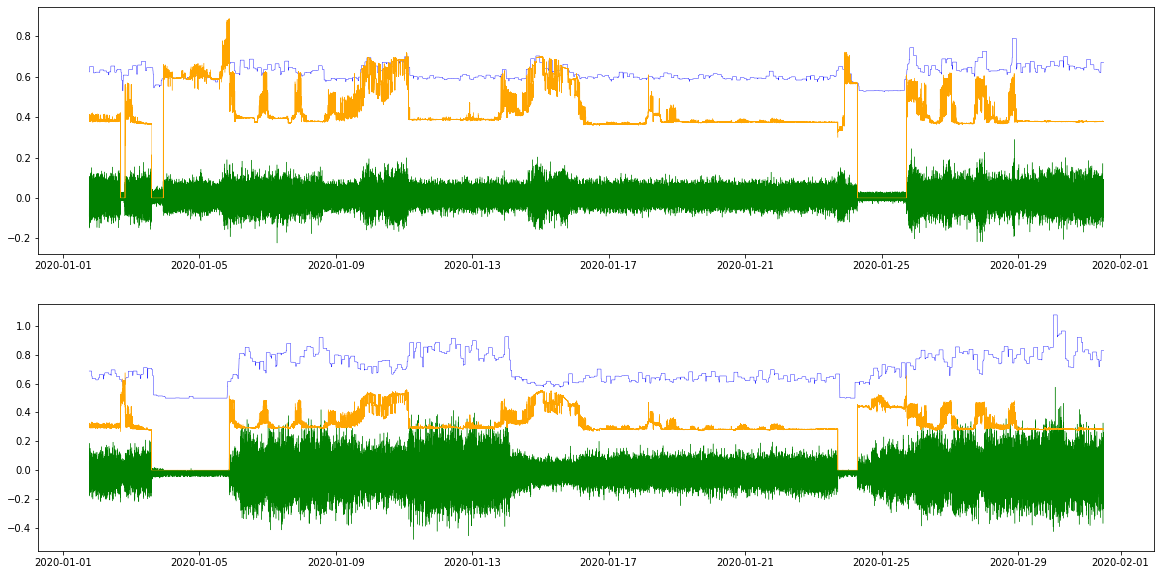

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), squeeze=False)
ax[0,0].plot(df_1['max'] + 0.5, lw=0.4, color='blue', label='max')
ax[0,0].plot(df_1['Vx'], lw=0.4, color='green', label='actual')
ax[0,0].plot(df_1['Ap']/6, lw=0.4, color='orange', label='actual')

ax[1,0].plot(df_2['max'] + 0.5, lw=0.4, color='blue', label='max')
ax[1,0].plot(df_2['Vx'], lw=0.4, color='green', label='actual')
ax[1,0].plot(df_2['Ap']/8, lw=0.4, color='orange', label='actual')



In [333]:
#from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kernel_density import KDEMultivariate

xy1 = np.vstack([df_1['Ap'], df_1['Vx']]).T
xy2 = np.vstack([df_2['Ap'], df_2['Vx']]).T


#kde1 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xy1)
#kde2 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xy2)
kde1 = KDEMultivariate(xy1, var_type='cc')
kde2 = KDEMultivariate(xy2, var_type='cc')

#z1 = sp.stats.gaussian_kde(xy1)(xy1)
#z2 = sp.stats.gaussian_kde(xy2)(xy2)

#z1 = kde1.score_samples(xy1)
#z2 = kde2.score_samples(xy2)

z1_orig = kde1.pdf(xy1)
z2_orig = kde1.pdf(xy2)

In [127]:
#zc1 = kde1.cdf(xy1)
#zc2 = kde2.cdf(xy1)

In [335]:
idx1 = z1.argsort()
idx2 = z2.argsort()
x1, y1, z1 = df_1['Ap'][idx1], df_1['Vx'][idx1], z1_orig[idx1]
x2, y2, z2 = df_2['Ap'][idx2], df_2['Vx'][idx2], z2_orig[idx2]



In [338]:
xy1[idx1], z1[0:10]

(array([[ 3.637 ,  0.29  ],
        [ 1.283 , -0.1211],
        [ 5.2356, -0.1318],
        ...,
        [ 2.2868,  0.0088],
        [ 2.2824,  0.0508],
        [ 2.3024, -0.0723]]),
 array([0.00172056, 0.00172056, 0.0017208 , 0.00172111, 0.00172333,
        0.00172341, 0.00172639, 0.00172659, 0.0017267 , 0.00172775]))

In [340]:
xy2[idx2], z2[0:10]

(array([[ 2.3272, -0.4561],
        [ 2.2958,  0.5752],
        [ 2.3398, -0.4814],
        ...,
        [ 2.2854,  0.0088],
        [ 2.2856,  0.0088],
        [ 2.2862,  0.0088]]),
 array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 2.55463815e-288,
        1.11006078e-282, 3.01720139e-256, 3.82423024e-256, 4.92284528e-236,
        1.09410075e-228, 3.40341939e-226]))

In [387]:
grid = np.mgrid[0:5.5:0.02, -0.6:0.6:0.01].reshape(2,-1).T
grid.shape
zfull1 = kde1.pdf(grid)
zfull2 = kde2.pdf(grid)


                        

In [391]:
xf1 = grid.T[0]
yf1 = grid.T[1]
xf2 = grid.T[0]
yf2 = grid.T[1]

yf1[zfull1 < 0.00001] = np.nan
yf2[zfull2 < 0.00001] = np.nan

<ipython-input-397-8b442fe9a4a0>:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax[0,0].scatter(x1, y1, c=z1, s=50, edgecolor='', cmap='coolwarm')
<ipython-input-397-8b442fe9a4a0>:12: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax[0,1].scatter(x2, y2, c=z2, s=50, edgecolor='', cmap='coolwarm')
<ipython-input-397-8b442fe9a4a0>:22: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax[2,0].scatter(xf1, yf1, c=zfull1, s=50, edgecolor='', cmap='viridis')
<ipython-input-397-8b442fe9a4a0>:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax[2,1].scatter(xf2, yf2, c=zfull2, s=50, edgecolor='', cmap='viridis')


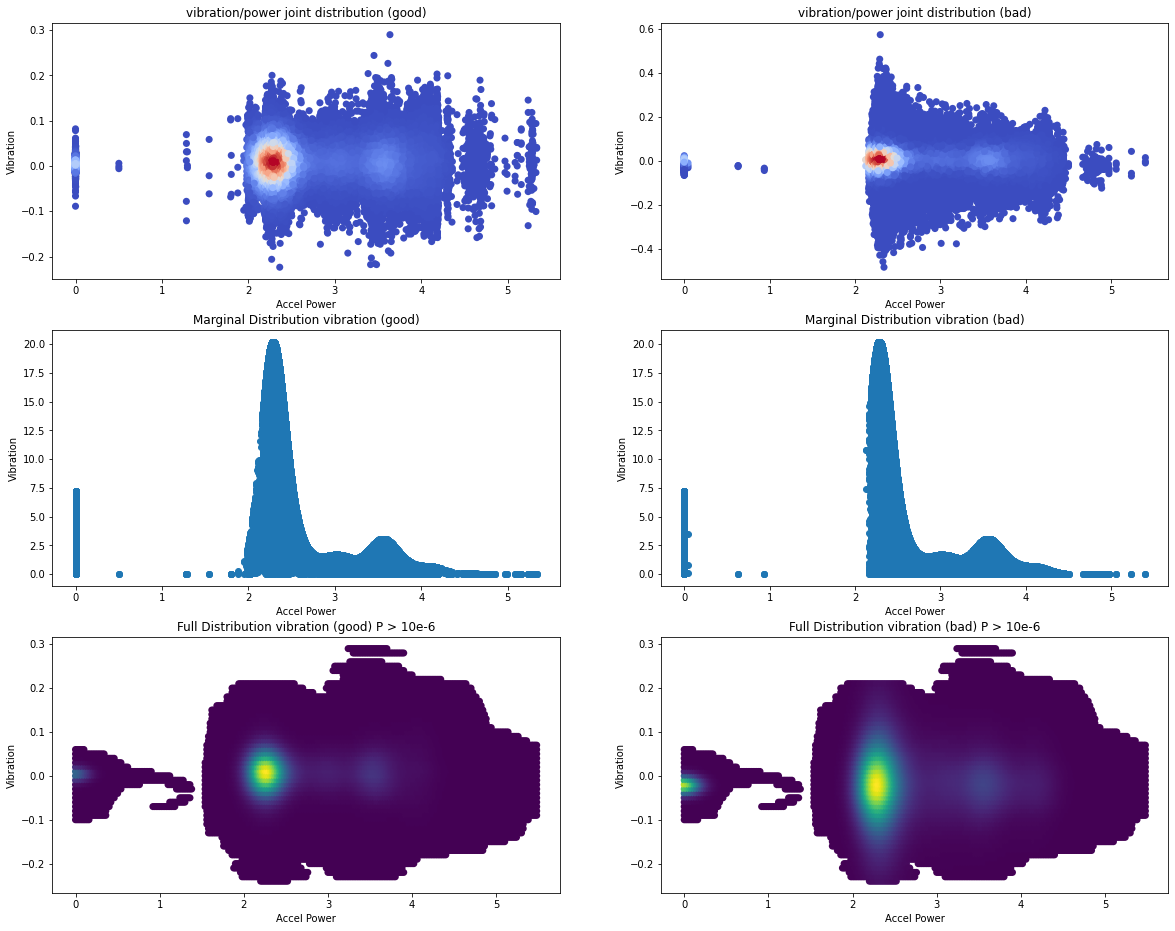

In [397]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(3, 2, figsize=(20, 16), squeeze=False)
#ax[0,0].scatter(df_1['Ap'], df_1['Vx'], color='green', lw=0.4)

ax[0,0].scatter(x1, y1, c=z1, s=50, edgecolor='', cmap='coolwarm')
ax[0,0].set_title('vibration/power joint distribution (good)')


#ax[0,1].contour(x1, y1, z1, levels=z1_a, colors='red', linewidths=1)
#ax[1,0].scatter(df_2['Ap'], df_2['Vx'], color='green', lw=0.4)

ax[0,1].scatter(x2, y2, c=z2, s=50, edgecolor='', cmap='coolwarm')
ax[0,1].set_title('vibration/power joint distribution (bad)')


ax[1,0].scatter(x1, z1)
ax[1,0].set_title('Marginal Distribution vibration (good)')
ax[1,1].scatter(x2, z2)
ax[1,1].set_title('Marginal Distribution vibration (bad)')


ax[2,0].scatter(xf1, yf1, c=zfull1, s=50, edgecolor='', cmap='viridis')
ax[2,0].set_title('Full Distribution vibration (good) P > 10e-6')
ax[2,1].scatter(xf2, yf2, c=zfull2, s=50, edgecolor='', cmap='viridis')
ax[2,1].set_title('Full Distribution vibration (bad) P > 10e-6')
#ax[2,1].set_title('vibration/power \"cross entropy\" (bad)')

for i in (0,1,2):
    for j in (0,1):
        ax[i,j].set_xlabel('Accel Power')
        ax[i,j].set_ylabel('Vibration')




### Try to render the probability density function as combination of Gaussians

In [309]:
# sort 
nn = 90000
idx11 = np.argsort(-1 * z1)[1:nn]

print (xy1[idx11].shape, xy1.shape)


from sklearn.mixture import BayesianGaussianMixture
BGM = BayesianGaussianMixture(n_components=3, verbose=1)
BGM.fit(xy1[idx11])

(89999, 2) (128580, 2)
Initialization 0
  Iteration 10
Initialization converged: True


BayesianGaussianMixture(n_components=3, verbose=1)

In [303]:
Y = BGM.predict_proba(xy1) #[idx11])

In [317]:
BGM.mean_prior_

array([2.33619931, 0.00811141])

#### Not exactly what I want

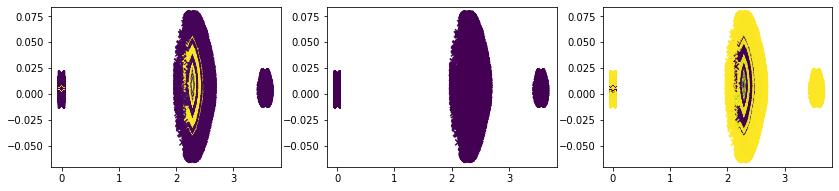

In [310]:
plt.figure(figsize=(14,10))
for i in range(3):
    plt.subplot(3,3,i+1)
    #plt.scatter(x1[idx11],y1[idx11],c=BGM.predict_proba(xy1[idx11])[:,i],cmap='viridis',marker='x')
    plt.scatter(x1[idx11],y1[idx11],c=BGM.predict_proba(xy1)[:nn-1,i],cmap='viridis',marker='x')



### Try a variational autoencoder
and let it guess 

In [ ]:
from pyod.models.vae import VAE
X = df_input['Vx'].values[9500:20000].reshape(-1,1)
XX = np.hstack([X,X])
print (XX.shape)
vaenc = VAE(encoder_neurons=[32, 8, 2], decoder_neurons=[2,8,32],
            latent_dim=2, gamma=1.1, capacity=0.4, verbosity=1)
vaenc.fit(XX)
vae = vaenc.predict_proba(XX)

<ipython-input-243-42c3fd419fb4>:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax[0,0].scatter(x1, y1, c=z1, s=50, edgecolor='', cmap='coolwarm')
<ipython-input-243-42c3fd419fb4>:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax[0,1].scatter(x1[m:n], y1[m:n], c=Y[m:n], s=50, edgecolor='', cmap='coolwarm')


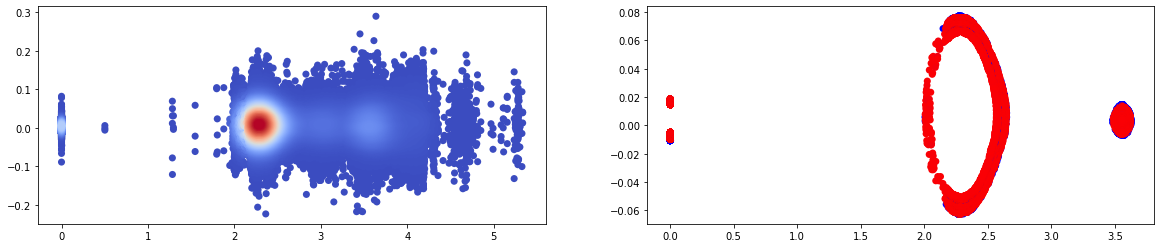

In [243]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4), squeeze=False)
#ax[0,0].scatter(df_1['Ap'], df_1['Vx'], color='green', lw=0.4)
m = 40000
n = 50000
ax[0,0].scatter(x1, y1, c=z1, s=50, edgecolor='', cmap='coolwarm')
ax[0,1].scatter(x1[m:n], y1[m:n], c=Y[m:n], s=50, edgecolor='', cmap='coolwarm')



In [191]:
Y

array([[0.96776935, 0.03223065, 0.        ],
       [0.55216393, 0.44783607, 0.        ],
       [0.146909  , 0.853091  , 0.        ],
       ...,
       [0.98460089, 0.01539911, 0.        ],
       [0.98038921, 0.01961079, 0.        ],
       [0.96617726, 0.03382274, 0.        ]])

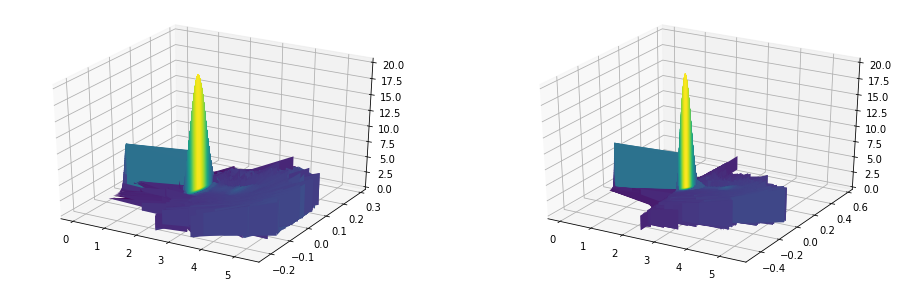

In [169]:
fig2 = plt.figure(figsize=(16, 5))
ax2 = fig2.add_subplot(1,2,1, projection='3d')
ax2.plot_surface(x1, y1, np.vstack([x1,z1]), rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax3 = fig2.add_subplot(1,2,2, projection='3d')
ax3.plot_surface(x2, y2, np.vstack([x2,z2]), rstride=1, cstride=1, cmap='viridis', edgecolor='none')


In [193]:
import lightgbm as lgb

params = {"objective": "regression"}

dtrain = lgb.Dataset(df_1[['max','on']][:80000], label=df_1['max'][:80000])
dvalid = lgb.Dataset(df_1[['max','on']][80000:])

model_lgb = lgb.train(params, train_set=dtrain)

predict = model_lgb.predict(df_input[['Vx', 'on']])


In [194]:
predict

array([0.02830253, 0.02830253, 0.02830253, ..., 0.05960131, 0.08010073,
       0.02830253])

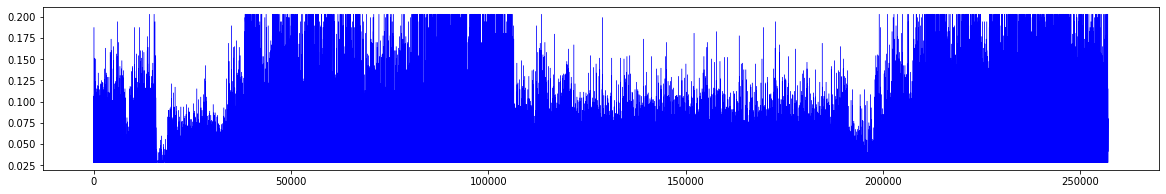

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(20, 3), squeeze=False)
ax[0,0].plot(predict, lw=0.4, color='blue', label='actual')


In [197]:
features = ['max_1']
#features.extend(hour_categories)
#features.extend(weekday_categories)
train_up_to = df_1.shape[0] - 1440
X_train = df_1[:train_up_to][features].T.to_numpy()
X_test = df_1[:train_up_to]['max'].values.reshape(-1, 1).T
Y_train = df_1[train_up_to:][features].T.to_numpy()
Y_test = df_1[train_up_to:]['max'].values.reshape(-1, 1).T

In [198]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, train_up_to, df_1[:train_up_to].shape

((1, 127140), (1, 127140), (1, 1440), (1, 1440), 127140, (127140, 11))

In [199]:
#4,4 have good r2 score for 36 featuers
net = prn.CreateNN([X_train.shape[0],4,4,X_test.shape[0]])

In [200]:
%%time
net = prn.train_LM(X_train,X_test,net,verbose=True,k_max=30,E_stop=1e1)

Iteration:  0 		Error:  69356.56586906931 	scale factor:  3.0
Iteration:  1 		Error:  147.70629465710186 	scale factor:  0.3
Iteration:  2 		Error:  144.78025568135072 	scale factor:  0.3
Iteration:  3 		Error:  144.6774254975471 	scale factor:  3.0
Iteration:  4 		Error:  144.65670185614619 	scale factor:  3.0
Iteration:  5 		Error:  144.6362086236625 	scale factor:  3.0
Iteration:  6 		Error:  144.61519409401112 	scale factor:  3.0
Iteration:  7 		Error:  144.59354504984736 	scale factor:  3.0
Iteration:  8 		Error:  144.5712355100122 	scale factor:  3.0
Iteration:  9 		Error:  144.54825589588148 	scale factor:  3.0
Iteration:  10 		Error:  144.52460043056976 	scale factor:  3.0
Iteration:  11 		Error:  144.50026452055783 	scale factor:  3.0
Iteration:  12 		Error:  144.47524408132412 	scale factor:  3.0
Iteration:  13 		Error:  144.44953524037746 	scale factor:  3.0
Iteration:  14 		Error:  144.42313410399854 	scale factor:  3.0
Iteration:  15 		Error:  144.39603652566598 	scale fac

In [205]:
import math
y = prn.NNOut(X_train,net)
ytest = prn.NNOut(Y_train,net)
print(
f'Training Output error analysis\n\
r2_score: {metrics.r2_score(X_test.T, y)} \n\
RMSE: {math.sqrt(metrics.mean_squared_error(X_test.T, y))} \n\
MAE: {metrics.mean_absolute_error(X_test.T, y)}'
)
print()
print(
f'Test Output error analysis\n\
r2_score: {metrics.r2_score(Y_test.T, ytest)} \n\
RMSE: {math.sqrt(metrics.mean_squared_error(Y_test.T, ytest))} \n\
MAE: {metrics.mean_absolute_error(Y_test.T, ytest)}'
)


Training Output error analysis
r2_score: 0.12122533764779853 
RMSE: 0.03364248827631957 
MAE: 0.02403449866757209

Test Output error analysis
r2_score: -0.6297136268781758 
RMSE: 0.024759792660032778 
MAE: 0.016865484628109353


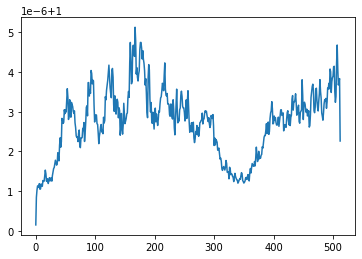

In [57]:
f1, P1xx_den = sp.signal.welch(df_1['Vx'].values, fs=1024, nperseg=1024)
f2, P2xx_den = sp.signal.welch(df_2['Vx'].values, fs=1024, nperseg=1024)
fe1 = np.exp(P1xx_den)
fe2 = np.exp(P1xx_den)
#plt.plot(f1, fe1)
plt.plot(f2, fe2)

In [59]:
sp.fft.fft(df_2['Vx'])

/home/markus/.local/lib/python3.8/site-packages/scipy/fft/_pocketfft/helper.py:97: FutureWarning: Series.flags is deprecated and will be removed in a future version
  copy = not x.flags['ALIGNED']


array([-2616.6371     -0.j        ,   -43.08512705-42.41345218j,
          57.17269729+21.98077182j, ...,   -59.44272061-58.19786469j,
          57.17269729-21.98077182j,   -43.08512705+42.41345218j])

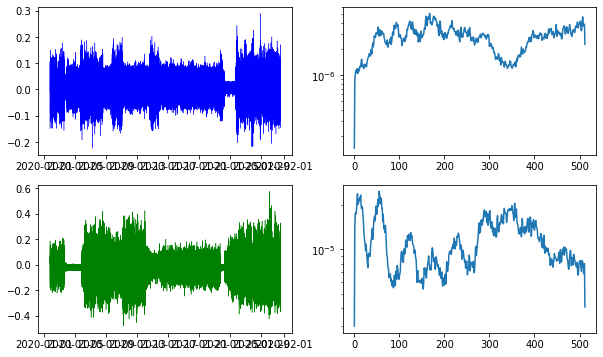

In [157]:
#arr = np.ones(chan.y_test.size)
fig, ax = plt.subplots(2, 2, figsize=(10, 6), squeeze=False)
ax[0,0].plot(df_1[['Vx']], lw=0.4, color='blue', label='actual')
ax[1,0].plot(df_2[['Vx']], lw=0.5, color='green', label='predicted')
ax[0,1].semilogy(f1, P1xx_den)
ax[1,1].semilogy(f2, P2xx_den)
#ax[0,0].legend()

In [105]:
from pyod.models.vae import VAE
X = df_input['Vx'].values[9500:20000].reshape(-1,1)
XX = np.hstack([X,X])
print (XX.shape)
vaenc = VAE(encoder_neurons=[32, 8, 2], decoder_neurons=[2,8,32],
            latent_dim=2, gamma=1.1, capacity=0.4, verbosity=1)
vaenc.fit(XX)
vae = vaenc.predict_proba(XX)

(10500, 2)


TypeError: __init__() got an unexpected keyword argument 'lr'

In [106]:
#from keras.utils.vis_utils import plot_model
#plot_model(vaenc.model_, show_shapes=True, show_layer_names=True)
vaenc.model_.predict(XX)


array([[0.00975618, 0.00975618],
       [0.00975618, 0.00975618],
       [0.00975618, 0.00975618],
       ...,
       [0.00975618, 0.00975618],
       [0.00975618, 0.00975618],
       [0.00975618, 0.00975618]], dtype=float32)

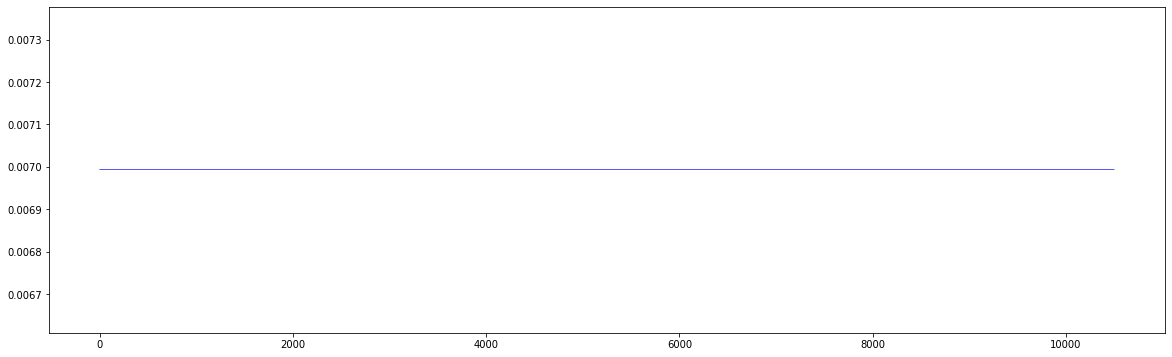

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6), squeeze=False)
ax[0,0].plot(vaenc.model_.predict(XX), lw=0.4, color='blue', label='actual')

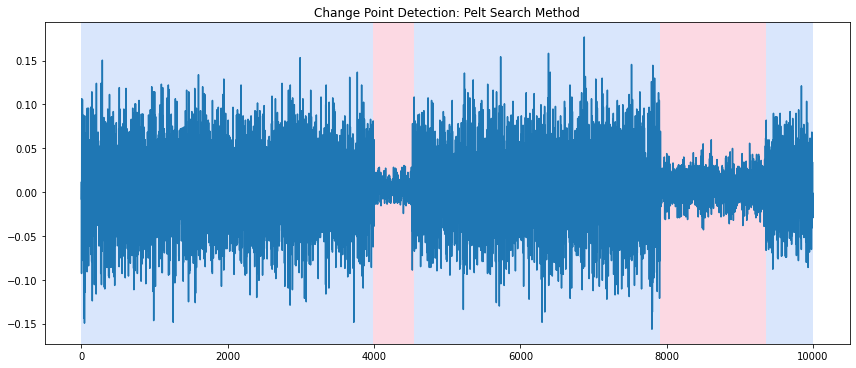

In [80]:
rpt.display(y[0:10000], results, figsize=(12, 5))
plt.title('Change Point Detection: Pelt Search Method')
plt.show() 

### Load data

In [12]:
model.evaluate(X_test, y_test)

39/39 [==============================] - 3s 70ms/step - loss: 0.4712 - mean_squared_error: 0.4712


[0.4711650609970093, 0.4711650609970093]

In [13]:
#model.evaluate(X_train, y_train)
X_train.shape

(6876, 100, 7)

In [14]:
X_train[-24:0].shape

(0, 100, 7)

In [15]:
act = y_train[-2:-1].reshape(-1,1)
pred = model.predict(X_train[-2:-1]).reshape(-1,1)

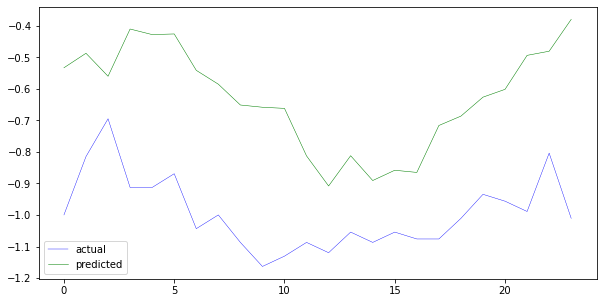

In [16]:
#arr = np.ones(chan.y_test.size)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), squeeze=False)
ax[0,0].plot(act, lw=0.4, color='blue', label='actual')
ax[0,0].plot(pred, lw=0.5, color='green', label='predicted')
#ax[1,0].plot(chan.y_hat[6700:], lw=1, color='brown', label='predicted')
ax[0,0].legend()


In [68]:
import torch
import torch.autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.dataset import random_split


def initialize_weights(model):
    print('initialize weights')
    if type(model) in [nn.Linear]:
        nn.init.xavier_uniform_(model.weight.data)
    elif type(model) in [nn.LSTM, nn.RNN, nn.GRU]:
        nn.init.xavier_uniform_(model.weight_hh_l0)
        nn.init.xavier_uniform_(model.weight_ih_l0)

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

class LSTM_2L(nn.Module):
    def __init__(self, n_features = 1, hidden_dims = [80,80], seq_length = 250,
                 batch_size = 64, n_predictions = 10, dropout = 0.1):
        super(LSTM_2L, self).__init__()
        print ('LSTM_2L', n_features, hidden_dims, seq_length, batch_size, n_predictions, dropout)

        self.n_features = n_features
        self.hidden_dim = hidden_dims[0]  # ignore second component for pytorch
        self.seq_length = seq_length
        self.num_layers = len(hidden_dims)
        self.batch_size = batch_size

        # using nn.LSTM so both layers end up with the same number of hidden dimensions
        self.lstm1 = nn.LSTM(
            input_size = self.n_features,
            hidden_size = self.hidden_dim,
            batch_first = True,
            dropout = dropout,
            num_layers = 2)

        self.linear = nn.Linear(self.hidden_dim, n_predictions)
        self.hidden = self.init_hidden_state()

    def init_hidden_state(self):
        #initialize hidden states (h_0, c_0)
        logger.debug('Hidden dimensions are: ' + str(self.num_layers) + ', ' +
                     str(self.batch_size) + ', ' + str(self.hidden_dim))

        return (
            Variable(torch.randn(self.num_layers, self.batch_size, self.hidden_dim)), #.to(self.device),
            Variable(torch.randn(self.num_layers, self.batch_size, self.hidden_dim)) #.to(self.device),
            )

    def forward(self, sequences, hidden = None):

        try:
            batch_size, seq_len, n_features = sequences.size()  # batch first
            logger.debug ('forward| Batch size: ' + str(batch_size) + ' Sequence length: ' + 
                          str(seq_len) + 'Output length:' + str(n_features))
        except Exception:
            logger.info ('forward issue in sequence: ' + str(sequences))

        #  for training
        if hidden is not None:
            self.hidden = hidden

        lstm1_out, hidden_out = self.lstm1(sequences, hidden)

        last_time_step = lstm1_out[:,-1,:]    # from (batch.size, input.size, hidden_dim.size)

        #lstm1_out_reshaped = lstm1_out.reshape(tuple((-1, *lstm1_out.shape[2:])))
        logger.debug ('Shapes ' + str(lstm1_out.shape) + ', ' + str(last_time_step.shape)
                      + ', ' + str(last_time_step.shape))

        #last_time_step = lstm1_out.view(-1, self.hidden_dims[0])

        #y_pred = self.linear(lstm1_out_reshaped)
        y_pred = self.linear(last_time_step)

        return y_pred, hidden_out


### Tensorboard support

Run `tensorboard --log=.\` in the notebooks directory to pick up training results

In [69]:
#instantiate summary writer
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

# instantiate LSTM with input shape from training data
lstm = LSTM_2L(n_features = X_train.shape[2], hidden_dims = (80,80),
                 seq_length = 100, batch_size = 64,
                 n_predictions = 24, dropout = 0.1)

loss_function = nn.MSELoss()

# lr 0.0005 is a bit low, same with 0.0009, 0.0012, 0.0019
#    0.0029 looks better (test loss is lower, too)
#    0.0039 is too high (sharp spike in epoch 37)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.0034)  

epochs = 45
train_hist = np.zeros(epochs)

# split out validation bucket
X_train_, X_validation_, y_train_, y_validation_ = train_test_split(X_train, y_train, train_size=0.8)

train_dataset=TensorDataset(torch.Tensor(X_train_),torch.Tensor(y_train_))
validation_dataset=TensorDataset(torch.Tensor(X_validation_),torch.Tensor(y_validation_))

train_loader = DataLoader(dataset=train_dataset, batch_size=64, drop_last=True, shuffle=True)
val_loader = DataLoader(dataset=validation_dataset, batch_size=64, drop_last=True, shuffle=True)


lstm.train()

print("Beginning model training...")

validation_losses = []

hidden = lstm.init_hidden_state()
for t in range(epochs):
    train_losses_batch = []
    print ('Epoch ', t)

    i = 0
    for X_batch_train, y_batch_train in train_loader:
        #print ('Batch ', i)

        #self.model.zero_grad()

        i += 1

        # detach hidden dimensions
        hidden = repackage_hidden(hidden)
        y_hat_train, hidden = lstm(X_batch_train, hidden=hidden)

        loss = loss_function(y_hat_train.float(), y_batch_train)
        train_loss_batch = loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        logger.debug('Batch ' + str(i-1) + ', Training loss ' + str(train_loss_batch))
        train_losses_batch.append(train_loss_batch)

    training_loss = np.mean(train_losses_batch)
    logger.debug ('After batch ' + str(i-1) + ', average training loss: ' + str(training_loss))
    
    writer.add_scalar('Loss/train', training_loss, t)
    train_losses_batch.append(training_loss)
    
    with torch.no_grad():
        val_losses_batch = []
        j = 0
        for X_val_batch, y_val_batch in val_loader:
            lstm.eval()
            y_hat_val, _ = lstm(X_val_batch, hidden=hidden)
            val_loss_batch = loss_function(y_hat_val.float(), y_val_batch).item()
            logger.debug('Validating batch ' + str(j) + ', validation loss: ' + str(val_loss_batch))
            val_losses_batch.append(val_loss_batch)
        validation_loss = np.mean(val_losses_batch)
        print('After batch ' + str(i-1) + ', average validation loss: ' + str(validation_loss))
        
        writer.add_scalar('Loss/validation', validation_loss, t)
        validation_losses.append(validation_loss)

    print(f"[{t+1}] Training loss: {training_loss} \t Validation loss: {validation_loss} ")
    if training_loss < 0.02 and validation_loss < 0.02:
        break

print('Training complete...')

# return the model after switching off training mode
lstm.eval()


#history = model.fit(X_train, y_train, batch_size=64, epochs=27, validation_split=0.2, 
#                    shuffle=True, callbacks=cbs, verbose=True)

LSTM_2L 10 (80, 80) 100 64 24 0.1
Beginning model training...
Epoch  0
After batch 84, average validation loss: 0.38793562991278513
[1] Training loss: 0.528482494985356 	 Validation loss: 0.38793562991278513 
Epoch  1
After batch 84, average validation loss: 0.33515115011306035
[2] Training loss: 0.3398441800299813 	 Validation loss: 0.33515115011306035 
Epoch  2
After batch 84, average validation loss: 0.3162312642449424
[3] Training loss: 0.3000164931311327 	 Validation loss: 0.3162312642449424 
Epoch  3
After batch 84, average validation loss: 0.2719405988852183
[4] Training loss: 0.2800734283292995 	 Validation loss: 0.2719405988852183 
Epoch  4
After batch 84, average validation loss: 0.25463778773943585
[5] Training loss: 0.25003153190893285 	 Validation loss: 0.25463778773943585 
Epoch  5
After batch 84, average validation loss: 0.21877374748388925
[6] Training loss: 0.22282580908607033 	 Validation loss: 0.21877374748388925 
Epoch  6
After batch 84, average validation loss: 0.2

LSTM_2L(
  (lstm1): LSTM(10, 80, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=80, out_features=24, bias=True)
)

In [70]:
torch.save(lstm.state_dict(), './mylstmintorch')
# get all parameters with values
#  all_my_parameters = list(lstm.lstm1.named_parameters())

In [71]:
# validate on the test set
test_dataset=TensorDataset(torch.Tensor(X_test),torch.Tensor(y_test))

test_loader = DataLoader(dataset=test_dataset, batch_size=64, drop_last=True)

i = 0
loss_test_batch = []
for X_batch_test, y_batch_test in test_loader:
    #print ('Batch ', i)

    i += 1
    
    with torch.no_grad():
        # detach hidden dimensions
        hidden = repackage_hidden(hidden)
        y_hat_test, hidden = lstm(X_batch_test, hidden=hidden)

        loss_test_batch.append(loss_function(y_hat_test.float(), y_batch_test).item())

    
loss_test = np.mean(loss_test_batch)
    
print('Loss Test ', loss_test)


fulltrain_dataset=TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train))
fulltrain_loader = DataLoader(dataset=train_dataset, batch_size=64, drop_last=True)

i = 0

loss_tr_batch = []
for X_batch_tr, y_batch_tr in fulltrain_loader:
    #print ('Batch ', i)

    i += 1
    
    with torch.no_grad():
        # detach hidden dimensions
        hidden = repackage_hidden(hidden)
        y_hat_tr, hidden = lstm(X_batch_tr, hidden=hidden)

        loss_tr_batch.append(loss_function(y_hat_tr.float(), y_batch_tr).item())
        prediction=y_hat_tr.float().numpy()
  
loss_tr = np.mean(loss_tr_batch)
    
print('Loss Train ', loss_tr)

    

Loss Test  0.39364978009344714
Loss Train  0.03463609759860179


In [72]:
prediction[-1]

array([-0.8395002 , -0.78541046, -0.774733  , -0.77409226, -0.80961925,
       -0.8505587 , -0.8513826 , -0.81975955, -0.77553904, -0.7984239 ,
       -0.7271275 , -0.67241806, -0.7251042 , -0.7545871 , -0.7072294 ,
       -0.64929605, -0.6648128 , -0.7086412 , -0.68326515, -0.63684744,
       -0.59898293, -0.618932  , -0.6487712 , -0.66742826], dtype=float32)

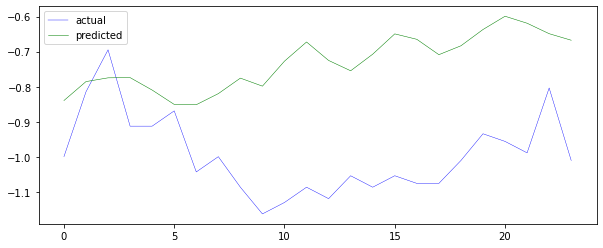

In [80]:
act = y_train[-2:-1].reshape(-1,1)
pred = prediction[-1]

#arr = np.ones(chan.y_test.size)
fig, ax = plt.subplots(1, 1, figsize=(10, 4), squeeze=False)
ax[0,0].plot(act, lw=0.4, color='blue', label='actual')
ax[0,0].plot(pred, lw=0.5, color='green', label='predicted')
#ax[1,0].plot(chan.y_hat[6700:], lw=1, color='brown', label='predicted')
ax[0,0].legend()

#### Training parameters

```
loss_metric: 'mse'    # minimize mean square error
optimizer: 'adam'     # sort of adaptive stochastic gradient descent
validation_split: 0.2 # 20% of the data is used for validating (val_loss)
dropout: 0.3          # ditch 30% of the LSTMs results when minimizing the loss function to avoid overfitting
lstm_batch_size: 64   # number of training data batches to evaluate per optimizer run to update the model’s parameters

patience: 10          # try at least 10 times to decrease val_loss smaller by ...
min_delta: 0.0003     # ... at least min_delta, else stop, so we get at least 'patience' epochs
epochs: 35            # no more than 35 passes through the entier training dataset.

l_s: 250              # lookback: num previous timesteps provided to model to predict future values
n_predictions: 10     # number of steps ahead to predict
```

This is defined in `telemanom/config.yaml`
<br>